#### 0. Utility methods

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_missing_value_percentage(data):
    temp = (data.isnull().sum()/data.shape[0])*100
    temp = temp[temp > 0]
    return temp

def draw_missing_value_percentage(data):
    temp = get_missing_value_percentage(data)
    plt.figure(figsize=(20,5))
    plt.xticks(rotation = 90)
    sns.barplot(temp)
    plt.show()

def set_na_to_median(data, column_name):
    condition = data[column_name].isna()
    median = data[column_name].median()
    data.loc[condition, column_name] = median

def set_na_to_value(data, column_name, value):
    condition = data[column_name].isna()
    data.loc[condition, column_name] = value

def box_scatter(data, columns, hue, figsize=(20,5)):
    fig, axes = plt.subplots(nrows=2, ncols=len(columns), figsize = figsize, sharey=True)
    for i,v in enumerate(columns):
        sns.boxplot(data = data, y = v, hue = hue, ax=axes[0][i])
        axes[0][i].set_title(v)
        sns.scatterplot(data = data, x=range(0, data.shape[0]), y = v, hue = hue, ax=axes[1][i])
        axes[1][i].set_title(v)
    plt.show()

def box_scatter_describe(data, columns, hue, figsize=(20,5)):
    box_scatter(data, columns, hue, figsize)
    condition = data[hue] == 1
    print(data[condition][columns].describe())

def box_scatter_compare(old_data, new_data, columns, hue, figsize=(20,5)):
    fig, axes = plt.subplots(nrows=4, ncols=len(columns), figsize = figsize, sharey=True)
    for i,v in enumerate(columns):
        sns.boxplot(data = old_data, y = v, hue = hue, ax=axes[0][i])
        sns.scatterplot(data = old_data, x=range(0, old_data.shape[0]), y = v, hue = hue, ax=axes[1][i])
        sns.boxplot(data = new_data, y = v, hue = hue, ax=axes[2][i])
        sns.scatterplot(data = new_data, x=range(0, new_data.shape[0]), y = v, hue = hue, ax=axes[3][i])
    plt.show()

def get_quantiled_data(data, column_name, quantile):
    condition = data[column_name] < data[column_name].quantile(quantile)    
    temp = data[condition]
    return temp

def get_data_loss(old, new):
    print(f'initial shape = {old.shape}')
    print(f'shape after cleaning = {new.shape}')
    print(f'data loss after cleaning = {round (100*(old.shape[0]-new.shape[0])/old.shape[0])}%')




# 1. Problem Statement

- in the telecom industry, customers churn(leave the service by a provider)
- the telecom industry has collected data for 3 months, there were churns in these 3 months.
- as a data scientist, we need to identify the patterns and reasons of these churns using ML modelling techniques
- the success of the model depends on the accuracy of predictions on the test(unseen) data. If we are able to predict the churn correctly for a reasonable number of customers in the unseen data, we can say which features impact the churn and what action items can be taken to reduce the churn(retain the customers)

# 2. First look at the data 

## 2.1 Loading and looking at the dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_dictionary = pd.read_csv('data_dictionary.csv')
inp0 = pd.read_csv('train.csv')

## 2.2 Shape

In [ ]:
inp0.shape

## 2.3 Column comprehension

In [ ]:
data = inp0
# a lot of columns have _6, _7, _8 in them, let's drop the suffix to understand what columns exist
columns = data.columns
columns = columns.str.replace('_6', '')
columns = columns.str.replace('_7', '')
columns = columns.str.replace('_8', '')
print(columns.unique().shape)
print(columns.unique().sort_values())

In [ ]:
data = inp0
# direction of calls => ic, og
# type of calls => loc, std, isd, roam, spl, others
# call between operators => within network(t2t, t2f, t2c), outside network(t2m, t2o)
# mobile network band => 2g, 3g
# loyalty related => aon
# data usage related => vol_2g, vol_3g
# calling usage related => mou => about 90 columns related to mou
# money related => arpu, rech_amt
# count related => rech_num, total_rech_data, count_rech_2g, count_rech_3g
# other parameters => fb_user
columns_to_select_1 = data.columns.str.contains('vbc')
columns_to_select_2 = data.columns.str.contains('')

data.loc[:, columns_to_select_1 & columns_to_select_2].head()

In [ ]:
data_dictionary

## 2.3 Observations

- there are about 172 columns, about 70k rows
- the columns can be understood as follows
    - direction of calls => ic, og
    - type of calls => loc, std, isd, roam, spl, others
    - call between operators => within network(t2t, t2f, t2c), outside network(t2m, t2o)
    - mobile network band => 2g, 3g
    - loyalty related => aon
    - data usage related => vol_2g, vol_3g
    - calling usage related => mou => about 90 columns related to mou
    - money related => arpu, rech_amt
    - type of recharges => nightly, sachet, monthly
    - count related => rech_num, total_rech_data, count_rech_2g, count_rech_3g
    - other parameters => fb_user

# 3. Preparation, Pre-Processing

## 3.1 Removal of columns with single value (one value and NaNs)

In [ ]:
data = inp0
temp = data.nunique() # gives unique count of all the columns
unique_condition_1 = temp == 1 # which columns have just 1 unique value
temp = temp[unique_condition_1]

# verify single value
print(temp)
data[temp.index]

In [ ]:
data = inp0
data['circle_id'].unique() # contains on 109, can be removed
data = data.drop(columns=['circle_id'])

data['loc_og_t2o_mou'].value_counts() # about 69k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['loc_og_t2o_mou'])

data['std_og_t2o_mou'].value_counts() # about 69k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2o_mou'])

data['loc_ic_t2o_mou'].value_counts() # about 69k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['loc_ic_t2o_mou'])

data['std_og_t2c_mou_6'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2c_mou_6'])

data['std_og_t2c_mou_7'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2c_mou_7'])

data['std_og_t2c_mou_8'].value_counts() # about 66k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2c_mou_8'])

data['std_ic_t2o_mou_6'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_ic_t2o_mou_6'])

data['std_ic_t2o_mou_7'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_ic_t2o_mou_7'])

data['std_ic_t2o_mou_8'].value_counts() # about 66k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_ic_t2o_mou_8'])

data['last_date_of_month_6'].value_counts() # all of them have same value
data = data.drop(columns=['last_date_of_month_6'])

data['last_date_of_month_7'].value_counts() # about 69k have same value, remaining few are nan
data = data.drop(columns=['last_date_of_month_7'])

data['last_date_of_month_8'].value_counts() # about 69k have same value, remaining few are nan
data = data.drop(columns=['last_date_of_month_8'])

inp1 = data


### 3.1.1 Observation
- about 13 columns are dropped

## 3.2 Change data type of datetime columns from object to datetime

In [ ]:
data = inp1
data.select_dtypes(include=['object'])
data['date_of_last_rech_6'] = pd.to_datetime(data['date_of_last_rech_6'])
data['date_of_last_rech_7'] = pd.to_datetime(data['date_of_last_rech_7'])
data['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'])
data['date_of_last_rech_data_6'] = pd.to_datetime(data['date_of_last_rech_data_6'])
data['date_of_last_rech_data_7'] = pd.to_datetime(data['date_of_last_rech_data_7'])
data['date_of_last_rech_data_8'] = pd.to_datetime(data['date_of_last_rech_data_8'])

inp2 = data # the changes above are by reference, but just to be sure that in case we make a copy, inp1 is still updated


## 3.3 Missing value treatment

In [ ]:
draw_missing_value_percentage(inp2)

In [ ]:
# missing value imputation
data = inp2

# treat all mou columns to set na values to median
temp = get_missing_value_percentage(data)
mou_columns_with_na = temp.index[temp.index.str.contains('mou')]
[set_na_to_median(data, column) for column in mou_columns_with_na]

# treat all og_others, ic_others to set na values to median
[set_na_to_median(data, column) for column in ['og_others_6', 'og_others_7', 'og_others_8','ic_others_6', 'ic_others_7', 'ic_others_8']]

# treat all date_of_last_rech to set na values to median
[set_na_to_median(data, column) for column in ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']]

# set date_of_last_rech_data same as date_of_last_rech
condition = data['date_of_last_rech_data_6'].isna()
data.loc[condition, 'date_of_last_rech_data_6'] = data.loc[condition, 'date_of_last_rech_6']

condition = data['date_of_last_rech_data_7'].isna()
data.loc[condition, 'date_of_last_rech_data_7'] = data.loc[condition, 'date_of_last_rech_7']

condition = data['date_of_last_rech_data_8'].isna()
data.loc[condition, 'date_of_last_rech_data_8'] = data.loc[condition, 'date_of_last_rech_8']

# treat all arpu_2g/3g to set na values to median
[set_na_to_median(data, column) for column in ['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8']]

# treat all counts of recharges to set na values to 0
[set_na_to_value(data, column, 0) for column in ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8']]

# total_rech_data is a sum of count_rech_2g and count_rech_3g, replacing the value will correct the data and impute missing values
data['total_rech_data_6'] = data['count_rech_2g_6'] + data['count_rech_3g_6']
data['total_rech_data_7'] = data['count_rech_2g_7'] + data['count_rech_3g_7']
data['total_rech_data_8'] = data['count_rech_2g_8'] + data['count_rech_3g_8']

# if total_rech_data is 0 (no recharge was done), max_rech_data and av_rech_amt_data is also 0
condition = data['total_rech_data_6'] == 0
data.loc[condition, 'max_rech_data_6'] = 0
data.loc[condition, 'av_rech_amt_data_6'] = 0

condition = data['total_rech_data_7'] == 0
data.loc[condition, 'max_rech_data_7'] = 0
data.loc[condition, 'av_rech_amt_data_7'] = 0

condition = data['total_rech_data_8'] == 0
data.loc[condition, 'max_rech_data_8'] = 0
data.loc[condition, 'av_rech_amt_data_8'] = 0

# assuming fb_user, night_pck_user to be 0 if information isn't available and mode is NaN
[set_na_to_value(data, column, 0) for column in ['fb_user_6', 'fb_user_7', 'fb_user_8','night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']]

draw_missing_value_percentage(data)
inp3 = data

### 3.3.1 Observation
- we have done some logical missing value imputations, we should validate the data with some sanity checks

## 3.4 Removal of empty rows

In [ ]:
data = inp3
threshold = 1
temp = data.isnull().mean(axis=1)*100 > threshold
print(f'% rows missing greater than {threshold}% of data = {round(data[temp].shape[0]*100/data.shape[0])}%')
print(data[temp].shape)
draw_missing_value_percentage(data[~temp])

### 3.4.1 Observation
- we don't need to remove rows as there is no missing value now.

## 3.5 Outlier treatment

In [ ]:
plt.figure(figsize = (30, 5))
plt.xticks(rotation = 90)
columns_to_remove = []
columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('fb_user')])
columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('night_pck_user')])
columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('monthly')])
columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('sachet')])
columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('date')])
columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('count')])
columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('rech_data')])
columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('rech_num')])

# columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('arpu')])
# columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('mou')])
# columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('vol')])
# columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('vbc')])
# columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('aon')])
# columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('amt')])
# columns_to_remove.extend(inp3.columns[inp3.columns.str.contains('others')])
sns.barplot(inp3.drop(columns = columns_to_remove).nunique().sort_values())
plt.show()

In [ ]:
from scipy.stats import zscore

def automated_outlier_treatment(data, exclude=[], method='iqr', threshold=3, type='cap'):
    numerical_cols = data.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        if col in exclude:
            continue
        if method == 'iqr':
            Q1 = data[col].quantile(0.01)
            Q3 = data[col].quantile(0.99)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            if(data[col].min() < 0):
                lower_bound = lower_bound
            else:
                lower_bound = 0
            
            if type == 'cap':
                data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
            elif type == 'rem':
                data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
            print(f'col = {col}, lower = {lower_bound}, upper = {upper_bound}, shape = {data.shape}')
        elif method == 'zscore':
            z_scores = zscore(data[col])
            if type == 'cap':
                data[col] = data[col].where(np.abs(z_scores) <= threshold, data[col].median())
            elif type == 'rem':
                data = data[(np.abs(z_scores) <= threshold)]
    return data

inp4 = automated_outlier_treatment(inp3.copy(), columns_to_remove, 'iqr', threshold=10, type='cap')
get_data_loss(inp3, inp4) # shouldn't be a data loss since we are capping
# box_scatter(inp4, numerical_cols, 'churn_probability', figsize=(1000, 5))
included_columns = set(inp3.columns.to_list()) - set(columns_to_remove)
# box_scatter_compare(inp3, inp4, included_columns, 'churn_probability', figsize = (600, 10))


# 4. Exploratory Data Analysis

## 4.1 Segmented univariate analysis over 'churn_probability'

### 4.1.1 arpu

In [ ]:
data = inp4

selected_columns = data.columns[data.columns.str.contains('arpu')]
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.1 observation
- the arpu of people who would churn is shrinking over time closer to 0
- downward trend of arpu is an indicator of churn

### 4.1.2 onnet, offnet

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('onnet')])
selected_columns.extend(data.columns[data.columns.str.contains('offnet')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.2 observation
- mou is higher for offnet in general
- customers who churned show a downward trend in mou as compared to customers who stayed, for both onnet and offset

### 4.1.3 loc_ic_mou, loc_og_mou

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('loc_ic_mou')])
selected_columns.extend(data.columns[data.columns.str.contains('loc_og_mou')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.3 observation
- incoming mou is higher than outgoing mou
- customers who churned show a downward trend in their average mou for both incoming and outgoing
- in case average mou of incoming and outgoing is going down, can be seen as a possibility of churn

### 4.1.4 std_ic_mou, std_og_mou

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('std_ic_mou')])
selected_columns.extend(data.columns[data.columns.str.contains('std_og_mou')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.4 observation
- there are more outgoing calls than incoming in std
- both incoming and outgoing mou has a downword trend for customers who have churned

### 4.1.5 isd_ic_mou, isd_og_mou

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('isd_ic_mou')])
selected_columns.extend(data.columns[data.columns.str.contains('isd_og_mou')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.5 observation
- isd has more incoming that outgoing
- average value of mou is trending downwards for both incoming and outgoing

### 4.1.6 aon

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('aon')])
selected_columns.append('aon')
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.6 observation
- customers having higher age on network usually stay
- looking at the median of customers who did not churn, it can be said that customers below 1000 days will have a higher chances of churn

### 4.1.7 rech_amt, rch_amt

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('rech_amt')])
selected_columns.extend(data.columns[data.columns.str.contains('rch_amt')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.7 observation
- recharges are going down month over month for customers who churned

### 4.1.8 recharge counts

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('rech_num')])
selected_columns.extend(data.columns[data.columns.str.contains('total_rech_data')])
selected_columns.extend(data.columns[data.columns.str.contains('count_rech_2g')])
selected_columns.extend(data.columns[data.columns.str.contains('count_rech_3g')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.8 observation
- recharge counts are also going down month over month for the customers who churned

### 4.1.9 data usage

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('vol')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.9 observation
- 3g usage is more than 2g
- usage of both 3g and 2g is trending downwards month over month

### 4.1.10 fb user, night pack user, monthly, sachet

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('fb_user')])
selected_columns.extend(data.columns[data.columns.str.contains('night_pck_user')])
selected_columns.extend(data.columns[data.columns.str.contains('monthly')])
selected_columns.extend(data.columns[data.columns.str.contains('sachet')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.10 observation
- count of fb user, night pack user, monthly user, sachet user is going down over months for churned customers

### 4.1.11 local within network (t2t, t2f, t2c)

In [ ]:
data = inp4.copy()

data['loc_ic_withinnetwork_mou_6'] = data['loc_ic_t2t_mou_6'] + data['loc_ic_t2f_mou_6']
data['loc_ic_withinnetwork_mou_7'] = data['loc_ic_t2t_mou_7'] + data['loc_ic_t2f_mou_7']
data['loc_ic_withinnetwork_mou_8'] = data['loc_ic_t2t_mou_8'] + data['loc_ic_t2f_mou_8']

data['loc_og_withinnetwork_mou_6'] = data['loc_og_t2t_mou_6'] + data['loc_og_t2f_mou_6'] + data['loc_og_t2c_mou_6']
data['loc_og_withinnetwork_mou_7'] = data['loc_og_t2t_mou_7'] + data['loc_og_t2f_mou_7'] + data['loc_og_t2c_mou_7']
data['loc_og_withinnetwork_mou_8'] = data['loc_og_t2t_mou_8'] + data['loc_og_t2f_mou_8'] + data['loc_og_t2c_mou_8']

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('withinnetwork')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.11 observation
- both incoming and outgoing within local network are trending downwards for churned customers

#### 4.1.11.1 local outside network t2m t2o

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('loc_ic_t2m')])
selected_columns.extend(data.columns[data.columns.str.contains('loc_og_t2m')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

#### 4.1.11.1 observation
- in general the incoming and outgoing from/to other operators is high for both churned and non churned customers

### 4.1.12 std within network (t2t, t2f, t2c)

In [ ]:
data = inp4.copy()

data['std_ic_withinnetwork_mou_6'] = data['std_ic_t2t_mou_6'] + data['std_ic_t2f_mou_6']
data['std_ic_withinnetwork_mou_7'] = data['std_ic_t2t_mou_7'] + data['std_ic_t2f_mou_7']
data['std_ic_withinnetwork_mou_8'] = data['std_ic_t2t_mou_8'] + data['std_ic_t2f_mou_8']

data['std_og_withinnetwork_mou_6'] = data['std_og_t2t_mou_6'] + data['std_og_t2f_mou_6']
data['std_og_withinnetwork_mou_7'] = data['std_og_t2t_mou_7'] + data['std_og_t2f_mou_7']
data['std_og_withinnetwork_mou_8'] = data['std_og_t2t_mou_8'] + data['std_og_t2f_mou_8']

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('withinnetwork')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.12 observation
- both incoming and outgoing within std network are trending downwards for churned customers
- for std outgoing calls are more than incoming

### 4.1.13 spl

In [ ]:
data = inp4

selected_columns = []
selected_columns.extend(data.columns[data.columns.str.contains('spl')])
print(selected_columns)
box_scatter_describe(data=data, columns=selected_columns, hue='churn_probability', figsize= (50, 10))

### 4.1.13 observation
- spl outgoing is decreasing month over month

# 5. Feature engineering and Variable Transformation

## 5.1 Create derived columns

In [ ]:
data = inp4

data['loc_ic_withinnetwork_mou_6'] = data.apply(lambda x: x['loc_ic_t2t_mou_6'] + x['loc_ic_t2f_mou_6'], axis=1)
data['loc_ic_withinnetwork_mou_7'] = data.apply(lambda x: x['loc_ic_t2t_mou_7'] + x['loc_ic_t2f_mou_7'], axis=1)
data['loc_ic_withinnetwork_mou_8'] = data.apply(lambda x: x['loc_ic_t2t_mou_8'] + x['loc_ic_t2f_mou_8'], axis=1)

data['loc_og_withinnetwork_mou_6'] = data.apply(lambda x: x['loc_og_t2t_mou_6'] + x['loc_og_t2f_mou_6'] + x['loc_og_t2c_mou_6'], axis=1)
data['loc_og_withinnetwork_mou_7'] = data.apply(lambda x: x['loc_og_t2t_mou_7'] + x['loc_og_t2f_mou_7'] + x['loc_og_t2c_mou_7'], axis=1)
data['loc_og_withinnetwork_mou_8'] = data.apply(lambda x: x['loc_og_t2t_mou_8'] + x['loc_og_t2f_mou_8'] + x['loc_og_t2c_mou_8'], axis=1)

data['std_ic_withinnetwork_mou_6'] = data.apply(lambda x: x['std_ic_t2t_mou_6'] + x['std_ic_t2f_mou_6'], axis=1)
data['std_ic_withinnetwork_mou_7'] = data.apply(lambda x: x['std_ic_t2t_mou_7'] + x['std_ic_t2f_mou_7'], axis=1)
data['std_ic_withinnetwork_mou_8'] = data.apply(lambda x: x['std_ic_t2t_mou_8'] + x['std_ic_t2f_mou_8'], axis=1)

data['std_og_withinnetwork_mou_6'] = data.apply(lambda x: x['std_og_t2t_mou_6'] + x['std_og_t2f_mou_6'], axis=1)
data['std_og_withinnetwork_mou_7'] = data.apply(lambda x: x['std_og_t2t_mou_7'] + x['std_og_t2f_mou_7'], axis=1)
data['std_og_withinnetwork_mou_8'] = data.apply(lambda x: x['std_og_t2t_mou_8'] + x['std_og_t2f_mou_8'], axis=1)

datetime_columns = data.columns[data.columns.str.contains('')]
data['date_of_last_rech_6'] = data['date_of_last_rech_6'].dt.day
data['date_of_last_rech_7'] = data['date_of_last_rech_7'].dt.day
data['date_of_last_rech_8'] = data['date_of_last_rech_8'].dt.day
data['date_of_last_rech_data_6'] = data['date_of_last_rech_data_6'].dt.day
data['date_of_last_rech_data_7'] = data['date_of_last_rech_data_7'].dt.day
data['date_of_last_rech_data_8'] = data['date_of_last_rech_data_8'].dt.day

inp5 = data

## 5.2 train test split

In [224]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(inp5, train_size=0.8, random_state=100)
# X_train = df_train.drop(columns=['id', 'churn_probability'])
X_train = df_train.drop(columns=['churn_probability'])
y_train = df_train['churn_probability']
# X_test = df_test.drop(columns=['id', 'churn_probability'])
X_test = df_test.drop(columns=['churn_probability'])
y_test = df_test['churn_probability']

print(f'df_train shape: {df_train.shape}')
print(f'df_test shape: {df_test.shape}')
print(df_train['churn_probability'].value_counts(normalize=True))
print(df_test['churn_probability'].value_counts(normalize=True))

df_train shape: (55999, 171)
df_test shape: (14000, 171)
churn_probability
0    0.897498
1    0.102502
Name: proportion, dtype: float64
churn_probability
0    0.900571
1    0.099429
Name: proportion, dtype: float64


## 5.2 observation
- we didn't have to stratify over churn_probability, the distribution of churn_probability in both train and test data is equally distributed

## 5.3 Scaling numerical columns

In [230]:
df_numerical_columns_to_scale = []
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('arpu')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('onnet')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('offnet')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('mou')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('aon')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('rech_amt')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('rch_amt')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('rech_num')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('total_rech_data')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('count_rech_2g')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('count_rech_3g')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('vol')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('monthly')])
df_numerical_columns_to_scale.extend(data.columns[data.columns.str.contains('sachet')])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train[df_numerical_columns_to_scale])
X_train_scaled = pd.DataFrame(scaler.transform(X_train[df_numerical_columns_to_scale]), columns=df_numerical_columns_to_scale)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[df_numerical_columns_to_scale]), columns=df_numerical_columns_to_scale)
# X_train[df_numerical_columns_to_scale] = scaler.transform(X_train[df_numerical_columns_to_scale])
# X_test[df_numerical_columns_to_scale] = scaler.transform(X_test[df_numerical_columns_to_scale])
# X_train = X_train_scaled
# X_test = X_test_scaled
X_train_scaled.head()

,arpu_6,arpu_7,arpu_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,onnet_mou_6,...,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
0,-0.876877,0.600367,-0.906720,-0.231898,-0.232079,-0.239058,-0.221138,-0.225221,-0.231283,-0.330603,...,-0.269532,-0.209883,-0.201927,-0.212607,-0.262939,-0.268468,-0.27573,-0.128093,-0.127708,-0.124883
1,-0.414118,-0.329881,-0.654696,-0.231898,-0.232079,-0.239058,-0.221138,-0.225221,-0.231283,0.525005,...,-0.269532,-0.209883,-0.201927,-0.212607,-0.262939,-0.268468,-0.27573,-0.128093,-0.127708,-0.124883
2,0.093323,0.637112,0.443886,-0.050214,0.281880,0.650275,-0.357335,-0.329894,-0.337739,-0.339339,...,6.435725,-0.209883,-0.201927,-0.212607,1.068374,1.540455,-0.27573,-0.128093,-0.127708,-0.124883
3,-0.426670,-0.721615,-0.036306,-0.231898,-0.232079,-0.239058,-0.221138,-0.225221,-0.231283,-0.261803,...,-0.269532,-0.209883,-0.201927,-0.212607,-0.262939,-0.268468,-0.27573,-0.128093,-0.127708,-0.124883
4,-0.178598,-0.181522,-0.315815,-0.231898,-0.232079,-0.239058,-0.221138,-0.225221,-0.231283,-0.410393,...,-0.269532,-0.209883,-0.201927,-0.212607,-0.262939,-0.268468,-0.27573,-0.128093,-0.127708,-0.124883


# 6. Modelling

## 6.1 PCA

In [231]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## 6.2 Scree plot

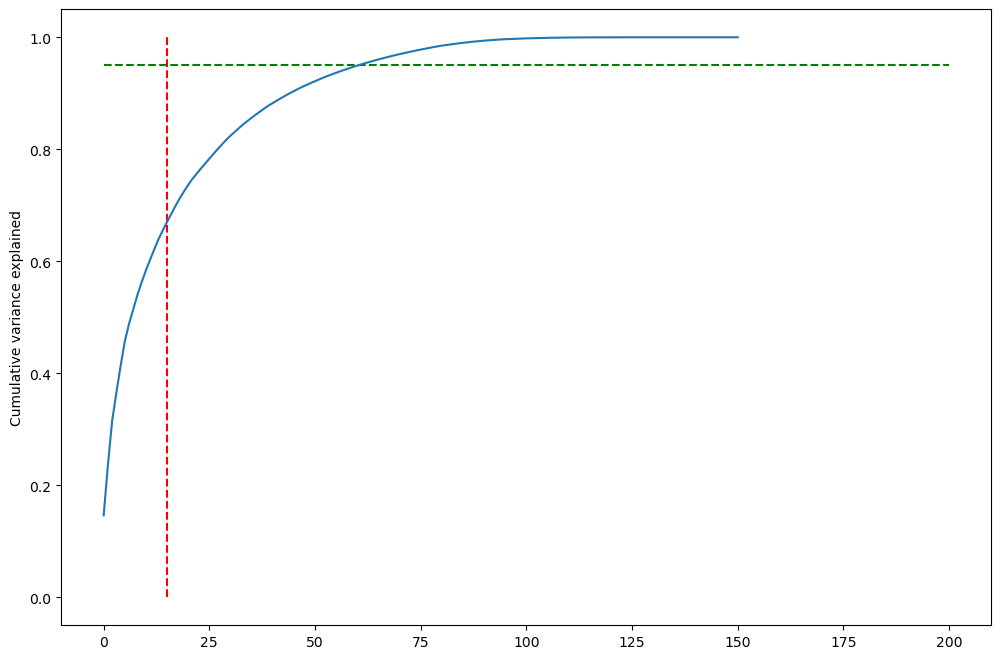

In [232]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=200, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

## 6.3 PCA again with about 0.95 explained variance

In [233]:
pca = PCA(0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(X_train_pca.shape)
print(X_test_pca.shape)


(55999, 62)
(14000, 62)


## 6.4 Logistic Regression after PCA

In [234]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
model_pca_logreg = logreg.fit(X_train_pca, y_train)
y_test_pred_prob = model_pca_logreg.predict_proba(X_test_pca)[:, 1]

accuracy_df = pd.DataFrame(y_test)
accuracy_df['pred_prob'] = y_test_pred_prob
accuracy_df['pred'] = accuracy_df['pred_prob'].apply(lambda x: 1 if x > 0.35 else 0)

In [235]:
print("{:2.2}".format(metrics.roc_auc_score(y_test, y_test_pred_prob)))
print(metrics.accuracy_score(accuracy_df['churn_probability'], accuracy_df['pred']))

0.88
0.9107857142857143


# 7. Get predictions on unseen data

In [239]:
test = pd.read_csv('test.csv')

In [237]:
test.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


## 7.1 run the same transformations on test data

In [240]:
data = test
data['circle_id'].unique() # contains on 109, can be removed
data = data.drop(columns=['circle_id'])

data['loc_og_t2o_mou'].value_counts() # about 69k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['loc_og_t2o_mou'])

data['std_og_t2o_mou'].value_counts() # about 69k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2o_mou'])

data['loc_ic_t2o_mou'].value_counts() # about 69k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['loc_ic_t2o_mou'])

data['std_og_t2c_mou_6'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2c_mou_6'])

data['std_og_t2c_mou_7'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2c_mou_7'])

data['std_og_t2c_mou_8'].value_counts() # about 66k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_og_t2c_mou_8'])

data['std_ic_t2o_mou_6'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_ic_t2o_mou_6'])

data['std_ic_t2o_mou_7'].value_counts() # about 67k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_ic_t2o_mou_7'])

data['std_ic_t2o_mou_8'].value_counts() # about 66k are 0 and remaining are nan, can be dropped
data = data.drop(columns=['std_ic_t2o_mou_8'])

data['last_date_of_month_6'].value_counts() # all of them have same value
data = data.drop(columns=['last_date_of_month_6'])

data['last_date_of_month_7'].value_counts() # about 69k have same value, remaining few are nan
data = data.drop(columns=['last_date_of_month_7'])

data['last_date_of_month_8'].value_counts() # about 69k have same value, remaining few are nan
data = data.drop(columns=['last_date_of_month_8'])

data['date_of_last_rech_6'] = pd.to_datetime(data['date_of_last_rech_6'])
data['date_of_last_rech_7'] = pd.to_datetime(data['date_of_last_rech_7'])
data['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'])
data['date_of_last_rech_data_6'] = pd.to_datetime(data['date_of_last_rech_data_6'])
data['date_of_last_rech_data_7'] = pd.to_datetime(data['date_of_last_rech_data_7'])
data['date_of_last_rech_data_8'] = pd.to_datetime(data['date_of_last_rech_data_8'])

# treat all mou columns to set na values to median
temp = get_missing_value_percentage(data)
mou_columns_with_na = temp.index[temp.index.str.contains('mou')]
[set_na_to_median(data, column) for column in mou_columns_with_na]

# treat all og_others, ic_others to set na values to median
[set_na_to_median(data, column) for column in ['og_others_6', 'og_others_7', 'og_others_8','ic_others_6', 'ic_others_7', 'ic_others_8']]

# treat all date_of_last_rech to set na values to median
[set_na_to_median(data, column) for column in ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']]

# set date_of_last_rech_data same as date_of_last_rech
condition = data['date_of_last_rech_data_6'].isna()
data.loc[condition, 'date_of_last_rech_data_6'] = data.loc[condition, 'date_of_last_rech_6']

condition = data['date_of_last_rech_data_7'].isna()
data.loc[condition, 'date_of_last_rech_data_7'] = data.loc[condition, 'date_of_last_rech_7']

condition = data['date_of_last_rech_data_8'].isna()
data.loc[condition, 'date_of_last_rech_data_8'] = data.loc[condition, 'date_of_last_rech_8']

# treat all arpu_2g/3g to set na values to median
[set_na_to_median(data, column) for column in ['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8']]

# treat all counts of recharges to set na values to 0
[set_na_to_value(data, column, 0) for column in ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8']]

# total_rech_data is a sum of count_rech_2g and count_rech_3g, replacing the value will correct the data and impute missing values
data['total_rech_data_6'] = data['count_rech_2g_6'] + data['count_rech_3g_6']
data['total_rech_data_7'] = data['count_rech_2g_7'] + data['count_rech_3g_7']
data['total_rech_data_8'] = data['count_rech_2g_8'] + data['count_rech_3g_8']

# if total_rech_data is 0 (no recharge was done), max_rech_data and av_rech_amt_data is also 0
condition = data['total_rech_data_6'] == 0
data.loc[condition, 'max_rech_data_6'] = 0
data.loc[condition, 'av_rech_amt_data_6'] = 0

condition = data['total_rech_data_7'] == 0
data.loc[condition, 'max_rech_data_7'] = 0
data.loc[condition, 'av_rech_amt_data_7'] = 0

condition = data['total_rech_data_8'] == 0
data.loc[condition, 'max_rech_data_8'] = 0
data.loc[condition, 'av_rech_amt_data_8'] = 0

# assuming fb_user, night_pck_user to be 0 if information isn't available and mode is NaN
[set_na_to_value(data, column, 0) for column in ['fb_user_6', 'fb_user_7', 'fb_user_8','night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']]

data = automated_outlier_treatment(data, columns_to_remove, 'iqr', threshold=10, type='cap')

data['loc_ic_withinnetwork_mou_6'] = data.apply(lambda x: x['loc_ic_t2t_mou_6'] + x['loc_ic_t2f_mou_6'], axis=1)
data['loc_ic_withinnetwork_mou_7'] = data.apply(lambda x: x['loc_ic_t2t_mou_7'] + x['loc_ic_t2f_mou_7'], axis=1)
data['loc_ic_withinnetwork_mou_8'] = data.apply(lambda x: x['loc_ic_t2t_mou_8'] + x['loc_ic_t2f_mou_8'], axis=1)

data['loc_og_withinnetwork_mou_6'] = data.apply(lambda x: x['loc_og_t2t_mou_6'] + x['loc_og_t2f_mou_6'] + x['loc_og_t2c_mou_6'], axis=1)
data['loc_og_withinnetwork_mou_7'] = data.apply(lambda x: x['loc_og_t2t_mou_7'] + x['loc_og_t2f_mou_7'] + x['loc_og_t2c_mou_7'], axis=1)
data['loc_og_withinnetwork_mou_8'] = data.apply(lambda x: x['loc_og_t2t_mou_8'] + x['loc_og_t2f_mou_8'] + x['loc_og_t2c_mou_8'], axis=1)

data['std_ic_withinnetwork_mou_6'] = data.apply(lambda x: x['std_ic_t2t_mou_6'] + x['std_ic_t2f_mou_6'], axis=1)
data['std_ic_withinnetwork_mou_7'] = data.apply(lambda x: x['std_ic_t2t_mou_7'] + x['std_ic_t2f_mou_7'], axis=1)
data['std_ic_withinnetwork_mou_8'] = data.apply(lambda x: x['std_ic_t2t_mou_8'] + x['std_ic_t2f_mou_8'], axis=1)

data['std_og_withinnetwork_mou_6'] = data.apply(lambda x: x['std_og_t2t_mou_6'] + x['std_og_t2f_mou_6'], axis=1)
data['std_og_withinnetwork_mou_7'] = data.apply(lambda x: x['std_og_t2t_mou_7'] + x['std_og_t2f_mou_7'], axis=1)
data['std_og_withinnetwork_mou_8'] = data.apply(lambda x: x['std_og_t2t_mou_8'] + x['std_og_t2f_mou_8'], axis=1)

datetime_columns = data.columns[data.columns.str.contains('')]
data['date_of_last_rech_6'] = data['date_of_last_rech_6'].dt.day
data['date_of_last_rech_7'] = data['date_of_last_rech_7'].dt.day
data['date_of_last_rech_8'] = data['date_of_last_rech_8'].dt.day
data['date_of_last_rech_data_6'] = data['date_of_last_rech_data_6'].dt.day
data['date_of_last_rech_data_7'] = data['date_of_last_rech_data_7'].dt.day
data['date_of_last_rech_data_8'] = data['date_of_last_rech_data_8'].dt.day

test = data

col = id, lower = 0, upper = 143796.53999999998, shape = (30000, 158)
col = arpu_6, lower = -2145.734669999991, upper = 3576.224449999985, shape = (30000, 158)
col = arpu_7, lower = -2176.8675449999987, upper = 3628.112574999998, shape = (30000, 158)
col = arpu_8, lower = -2224.6309049999995, upper = 3707.718174999999, shape = (30000, 158)
col = onnet_mou_6, lower = 0, upper = 3395.801749999988, shape = (30000, 158)
col = onnet_mou_7, lower = 0, upper = 3670.4652499999975, shape = (30000, 158)
col = onnet_mou_8, lower = 0, upper = 3658.4692499999883, shape = (30000, 158)
col = offnet_mou_6, lower = 0, upper = 3763.6734999999885, shape = (30000, 158)
col = offnet_mou_7, lower = 0, upper = 3849.231749999999, shape = (30000, 158)
col = offnet_mou_8, lower = 0, upper = 3774.4282499999954, shape = (30000, 158)
col = roam_ic_mou_6, lower = 0, upper = 533.4649999999975, shape = (30000, 158)
col = roam_ic_mou_7, lower = 0, upper = 375.95749999999884, shape = (30000, 158)
col = roam_ic_mou_8, l

/var/folders/wn/_ww3bv4j7r31s6vbkjxd4l9h0000gn/T/ipykernel_91580/563989801.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['loc_ic_withinnetwork_mou_6'] = data.apply(lambda x: x['loc_ic_t2t_mou_6'] + x['loc_ic_t2f_mou_6'], axis=1)
/var/folders/wn/_ww3bv4j7r31s6vbkjxd4l9h0000gn/T/ipykernel_91580/563989801.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['loc_ic_withinnetwork_mou_7'] = data.apply(lambda x: x['loc_ic_t2t_mou_7'] + x['loc_ic_t2f_mou_7'], axis=1)
/var/folders/wn/_ww3bv4j7r31s6vbkjxd4l9h0000gn/T/ipy

## 7.2 PCA and Prediction on unseen data

In [253]:
test_scaled = pd.DataFrame(scaler.transform(test[df_numerical_columns_to_scale]), columns=df_numerical_columns_to_scale)
test_pca = pca.transform(test_scaled)

test_pred_prob = model_pca_logreg.predict_proba(test_pca)[:, 1]

test['pred_prob'] = test_pred_prob
test['churn_probability'] = test['pred_prob'].apply(lambda x: 1 if x > 0.35 else 0)

In [254]:
test['churn_probability'].value_counts()

churn_probability
0    29227
1      773
Name: count, dtype: int64

In [246]:
test[['id', 'churn_probability']].to_csv('pca_logreg.csv', index=False)

In [244]:
sample = pd.read_csv('sample.csv')
sample['churn_probability'].value_counts()

churn_probability
0    30000
Name: count, dtype: int64

# Conclusions